# Calculate advection in ANHA4

In [4]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [64]:
import glob
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [6]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

# Dissolved Barium advection

local time derivative = adv + conv + diffu + sms + decay:

$$
\frac{\partial T}{\partial t} = \vec{v}\cdot\nabla T + w\frac{\partial T}{\partial z} + \nu\Delta T + SMS(x, y, t) + \lambda T
$$

Advection term in finite difference:

$$
\vec{v}\cdot\nabla T = u\frac{\delta T}{\delta x} + v\frac{\delta T}{\delta y} = \mathrm{vozocrtx}\frac{\delta_i T}{e1t} + \mathrm{vomecrty}\frac{\delta_j T}{e2t} \\
\delta_i,\delta_i = \mathrm{difference\ along\ the\ direction\ of\ ANHA4\ grid}
$$

In [19]:
#FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'
#ptrc_obj = nc.Dataset(FName)
#nav_lat = ptrc_obj.variables['nav_lat'][:]
#nav_lon = ptrc_obj.variables['nav_lon'][:]
#deptht = ptrc_obj.variables['deptht'][:]
## Tracer operations
#Ba = ptrc_obj.variables['Ba'][:, :20, :, :]
#Ba[Ba==0]=np.nan
#print(Ba.shape)
#Ba = np.nanmean(Ba, 1)
#print(Ba.shape)

In [8]:
save_var = {'Ba0':Ba}
scipy.io.savemat('../../_data/Exchange/Ba_baserun.mat', mdict=save_var)

In [20]:
MAT = scipy.io.loadmat('../../_data/Exchange/Ba_baserun.mat')
Ba = MAT['Ba0'][:]
#
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vomecrty0 = MAT['vomecrty0'][:]

In [33]:
Ba_mean = np.nanmean(Ba, 0)
u_mean = np.nanmean(vozocrtx0, 0)
v_mean = np.nanmean(vomecrty0, 0)
sp_mean = np.sqrt(u_mean*u_mean + v_mean*v_mean)

In [23]:
dBax, dBay = Ats.central_diff(Ba_mean)
advBa = u_mean*dBax/e1t[0, :, :] + v_mean*dBay/e2t[0, :, :]

In [49]:
lev_adv = np.array([-1.05, -0.75, -0.45, -0.15, 0.15, 0.45, 0.75, 1.05])

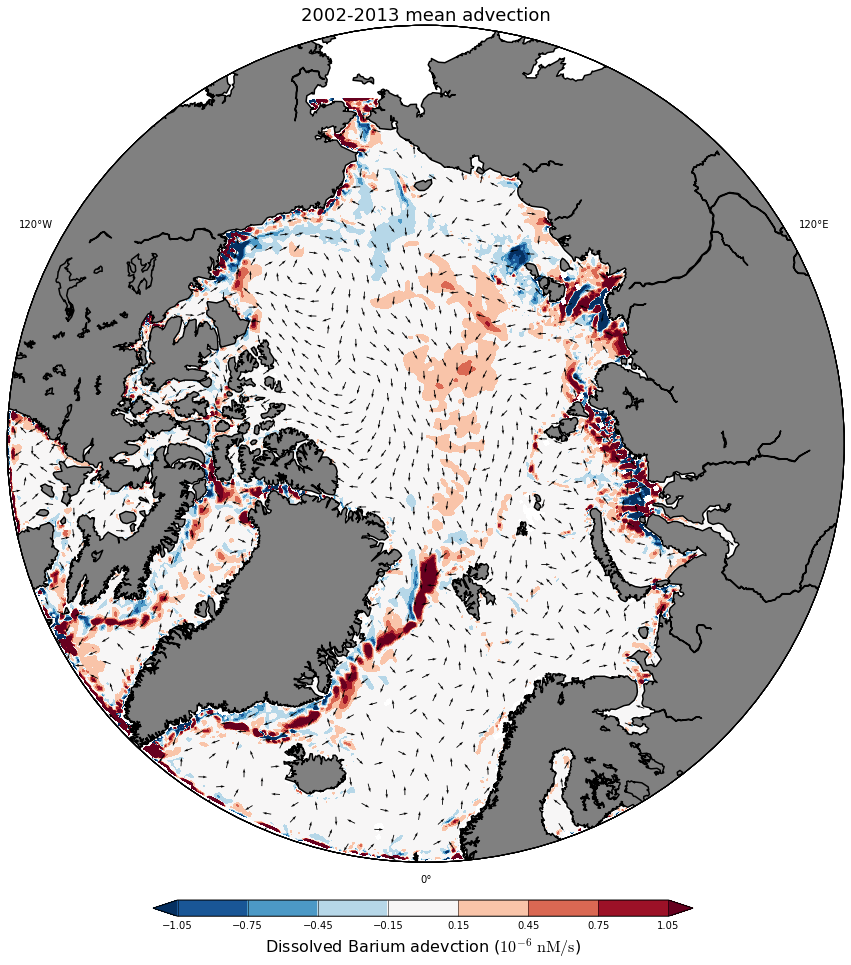

In [53]:
n=10
fig=plt.figure(figsize=(15, 15));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, advBa*1e6, lev_adv, cmap=plt.cm.RdBu_r, extend='both')
proj.quiver(x[::n, ::n], y[::n, ::n], u_mean[::n, ::n]/sp_mean[::n, ::n], v_mean[::n, ::n]/sp_mean[::n, ::n],
            width=0.001, scale=95)
ax.set_title('2002-2013 mean advection', fontsize=18)

cax = fig.add_axes([0.26, 0.075, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Dissolved Barium adevction ($\mathrm{10^{-6}\ nM/s}$)', fontsize=16)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev_adv)

In [52]:
print(' If 0.75e-6 nM/s then {} nM/month'.format(60*60*24*30*0.75e-6))

 If 0.75e-6 nM/s then 1.944 nM/month


In [60]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [62]:
def plot_uv(nav_lon, nav_lat, u, v, lev, ax):
    n=4
    sp = np.sqrt(u*u+v*v)
    u = u/sp
    v = v/sp
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS=proj.contourf(x, y, sp, lev, cmap=plt.cm.gist_ncar_r, extend='both')
    proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.0015, scale=95)

In [ ]:
u45 = vozocrtx0[45, :, :]; v45 = vomecrty0[45, :, :]
sp45 = np.sqrt(u45*u45+v45*v45)
    u = u/sp
    v = v/sp